In [15]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import datetime

In [16]:
import sys
sys.path.append('library');

In [17]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


# Variable globales

In [18]:
import json
from pathlib import Path

home = str(Path.home());

## Load json
fd = open(os.path.join(home,'cnn_emotion4_kfold.json'));
DATA = json.load(fd);
fd.close()

## Seed for the random variables
seed_number = 0;

## Dataset 
dataset_base_dir    = DATA["dataset_base_dir"]; 
dataset_labels_file = DATA['dataset_labels_file'];
dataset_name        = DATA['dataset_name'];

## Kfold 
K                 = DATA["kfold"]; # Variable K of kfold
enable_stratified = DATA["enable_stratified"]; # True: Stratified kfold False: Enable kfold 

## Training hyperparameters
EPOCAS     = DATA["epochs"];
BATCH_SIZE = DATA["batch_size"];

## Model of network
## 'mobilenet_v3', 'efficientnet_b3', 'inception_v3', 'inception_resnet_v2', 'resnet_v2_50'
model_type = DATA["model_type"];

## Output
output_base_dir = DATA["output_base_dir"];

##############################################

print('   dataset_base_dir:',dataset_base_dir)
print('dataset_labels_file:',dataset_labels_file)
print('       dataset_name:',dataset_name)
print('         model_type:',model_type)
print('                  K:',K)
print('  enable_stratified:',enable_stratified)
print('             EPOCAS:',EPOCAS)
print('         BATCH_SIZE:',BATCH_SIZE)
print('    output_base_dir:',output_base_dir)


   dataset_base_dir: /mnt/boveda/DATASETs/PATIENT-IMAGES/patient_people/train
dataset_labels_file: emotion4.work1.csv
       dataset_name: dataset_patient_people
         model_type: efficientnet_b3
                  K: 5
  enable_stratified: True
             EPOCAS: 50
         BATCH_SIZE: 32
    output_base_dir: /mnt/boveda/DOCTORADO2/cnn_emotion4/cross-validation


# Parametros de entrada

In [21]:
for n in range(len(sys.argv)):
    if sys.argv[n]=='--dataset-dir':
        dataset_base_dir=sys.argv[n+1];
    elif sys.argv[n]=='--dataset-file':
        dataset_labels_file=sys.argv[n+1];
    elif sys.argv[n]=='--dataset-name':
        dataset_name=sys.argv[n+1];
    elif sys.argv[n]=='--model':
        model_type=sys.argv[n+1];
    elif sys.argv[n]=='--kfold':
        K=int(sys.argv[n+1]);
    elif sys.argv[n]=='--enable-stratified':
        enable_stratified=bool(sys.argv[n+1]);
    elif sys.argv[n]=='--epochs':
        EPOCAS=int(sys.argv[n+1]);
    elif sys.argv[n]=='--batch-size':
        BATCH_SIZE=int(sys.argv[n+1]);
    elif sys.argv[n]=='--output-dir':
        output_base_dir=sys.argv[n+1];
        
print('   dataset_base_dir:',dataset_base_dir)
print('dataset_labels_file:',dataset_labels_file)
print('       dataset_name:',dataset_name)
print('         model_type:',model_type)
print('                  K:',K)
print('  enable_stratified:',enable_stratified)
print('             EPOCAS:',EPOCAS)
print('         BATCH_SIZE:',BATCH_SIZE)
print('    output_base_dir:',output_base_dir)

   dataset_base_dir: /mnt/boveda/DATASETs/PATIENT-IMAGES/patient_people/train
dataset_labels_file: emotion4.work1.csv
       dataset_name: dataset_patient_people
         model_type: efficientnet_b3
                  K: 5
  enable_stratified: True
             EPOCAS: 50
         BATCH_SIZE: 32
    output_base_dir: /mnt/boveda/DOCTORADO2/cnn_emotion4/cross-validation


# Set seed of random variables


In [4]:
np.random.seed(seed_number)
tf.keras.utils.set_random_seed(seed_number);

# Setting the cross-validation kfold


In [5]:
from sklearn.model_selection import KFold, StratifiedKFold

if enable_stratified:
    output_dir = os.path.join(output_base_dir,dataset_name,'skfold');
    kf = StratifiedKFold(n_splits = K, shuffle = True, random_state = seed_number);
else:
    output_dir = os.path.join(output_base_dir,dataset_name,'kfold');
    kf  = KFold(n_splits = K, shuffle=True, random_state=seed_number); 

# Loading data of dataset

In [6]:
# Load filenames and labels
train_data = pd.read_csv(os.path.join(dataset_base_dir,dataset_labels_file));
print(train_data)
# Setting labels
Y   = train_data[['label']];
L=np.shape(Y)[0];

                   filename     label
0     patient/filename1.png  Negative
1     patient/filename2.png  Negative
2     patient/filename3.png      Pain
3     patient/filename4.png  Negative
4     patient/filename5.png      Pain
..                      ...       ...
626  people/filename349.png    Neutro
627  people/filename350.png    Neutro
628  people/filename351.png    Neutro
629  people/filename352.png    Neutro
630  people/filename354.png  Positive

[631 rows x 2 columns]


# Data augmentation configuration

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

idg    = ImageDataGenerator(rescale=1./255,
                            rotation_range = 10,
                            width_shift_range= 0.07,
                            height_shift_range= 0.07,
                            horizontal_flip=True,
                            shear_range=1.25,
                            zoom_range = [0.75, 1.25] 
                            )

idg_val= ImageDataGenerator(rescale=1./255 )



# Auxiliar function

In [8]:
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

# Creating output directory

In [9]:

try: 
    os.makedirs(output_dir,exist_ok = True) 
except: 
    pass


# Cross-validation


Fold: 1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1536)              10783528  
                                                                 
 dense (Dense)               (None, 4)                 6148      
                                                                 
Total params: 10,789,676
Trainable params: 6,148
Non-trainable params: 10,783,528
_________________________________________________________________
Found 504 validated image filenames belonging to 4 classes.
Found 127 validated image filenames belonging to 4 classes.
Epoch 1/50
16/16 [==============================] - ETA: 0s - loss: 1.2887 - accuracy: 0.3869
Epoch 1: val_accuracy improved from -inf to 0.46457, saving model to /mnt/boveda/DOCTORADO2/cnn_emotion4/cross-validation/skfold/model_1.h5
16/16 [==============================] - 99s 5s/step - loss: 1.2887 - acc

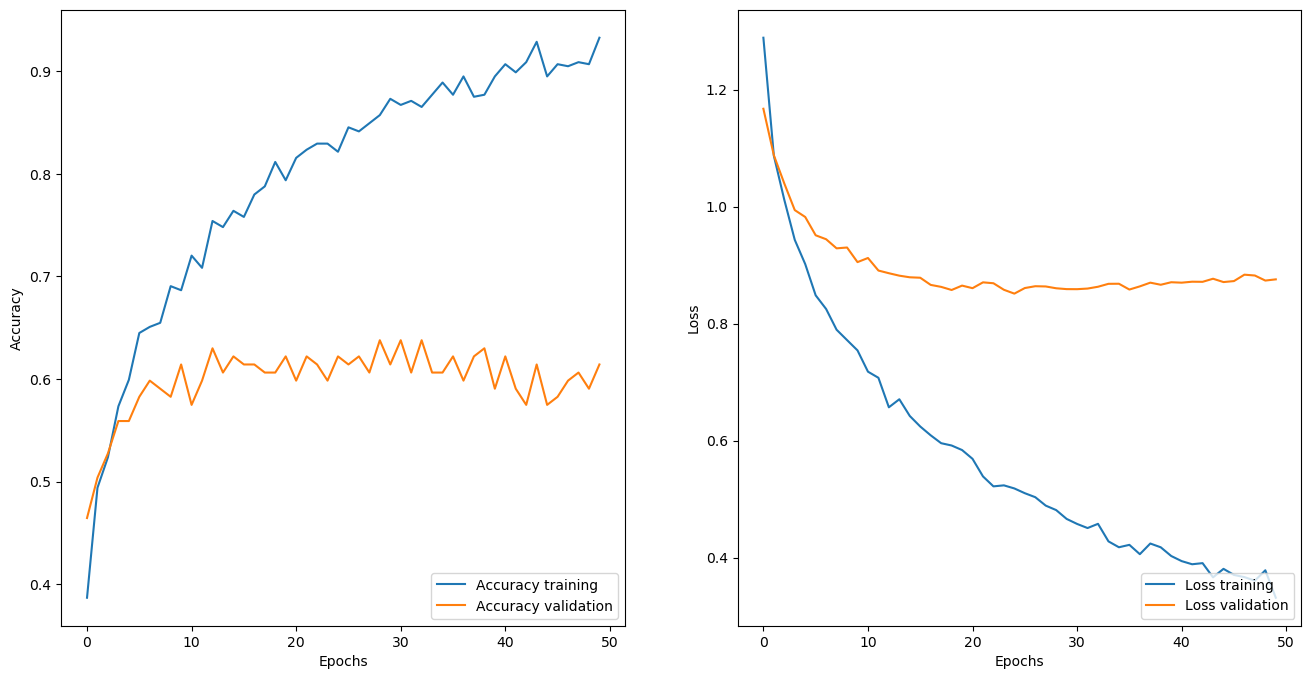

max_val_acc 0.6377952694892883
4/4 [==============================] - 15s 4s/step - loss: 0.8604 - accuracy: 0.6378
{'loss': 0.8603922128677368, 'accuracy': 0.6377952694892883} 



Fold: 2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1536)              10783528  
                                                                 
 dense (Dense)               (None, 4)                 6148      
                                                                 
Total params: 10,789,676
Trainable params: 6,148
Non-trainable params: 10,783,528
_________________________________________________________________
Found 505 validated image filenames belonging to 4 classes.
Found 126 validated image filenames belonging to 4 classes.
Epoch 1/50
16/16 [==============================] - ETA: 0s - loss: 1.2378 - accuracy: 0.3901
Epoch 1: val_accuracy improved fr

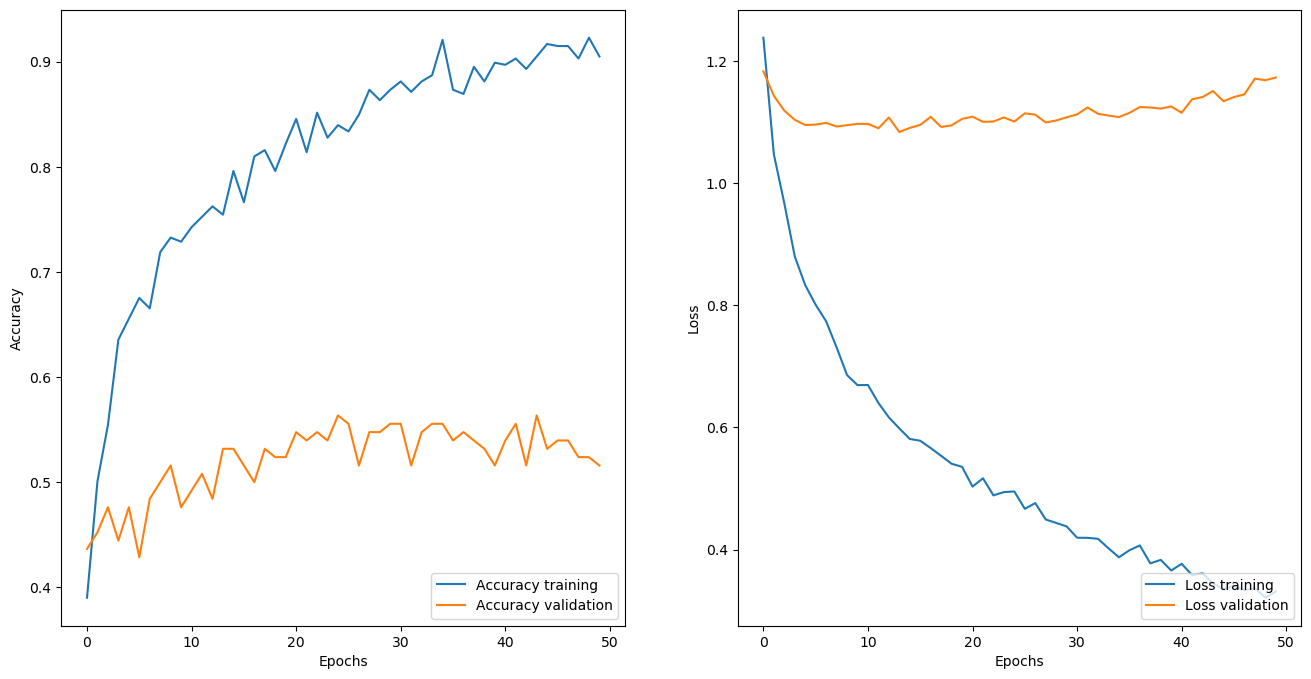

max_val_acc 0.5634920597076416
4/4 [==============================] - 14s 3s/step - loss: 1.1005 - accuracy: 0.5635
{'loss': 1.1004865169525146, 'accuracy': 0.5634920597076416} 



Fold: 3
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1536)              10783528  
                                                                 
 dense (Dense)               (None, 4)                 6148      
                                                                 
Total params: 10,789,676
Trainable params: 6,148
Non-trainable params: 10,783,528
_________________________________________________________________
Found 505 validated image filenames belonging to 4 classes.
Found 126 validated image filenames belonging to 4 classes.
Epoch 1/50
16/16 [==============================] - ETA: 0s - loss: 1.2588 - accuracy: 0.4198
Epoch 1: val_accuracy improved fr

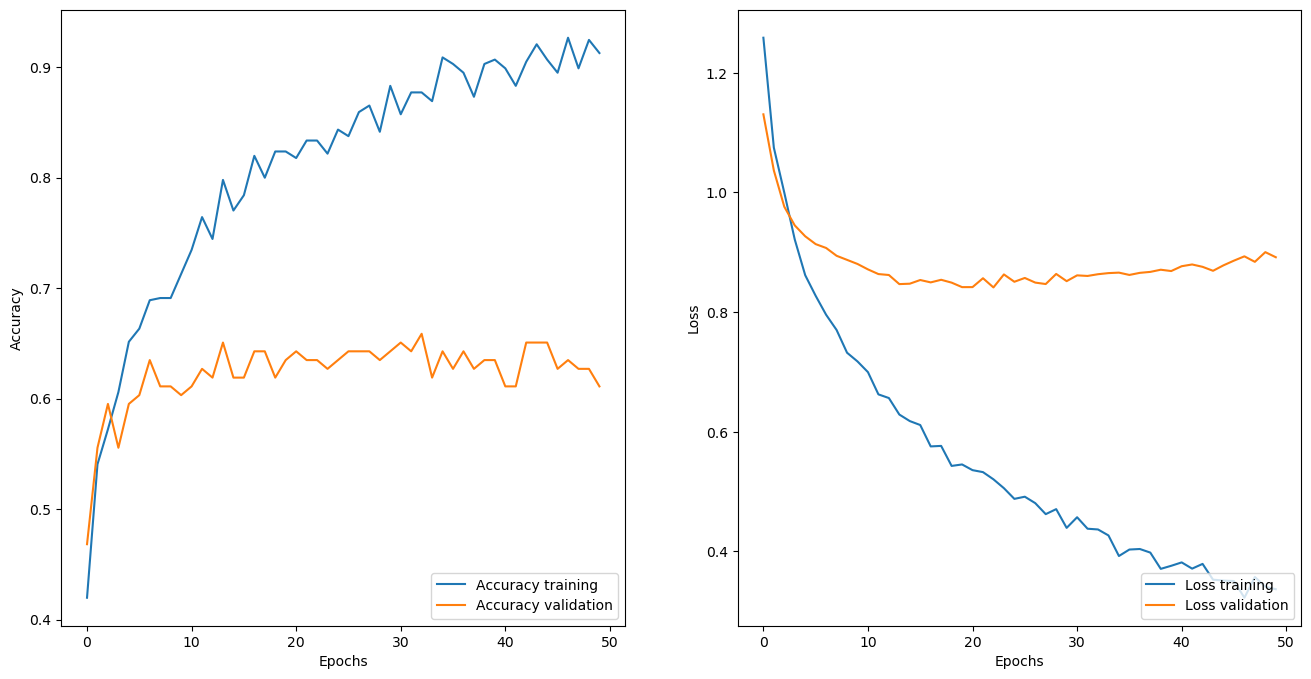

max_val_acc 0.658730149269104
4/4 [==============================] - 15s 4s/step - loss: 0.8634 - accuracy: 0.6587
{'loss': 0.8633807897567749, 'accuracy': 0.658730149269104} 



Fold: 4
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1536)              10783528  
                                                                 
 dense (Dense)               (None, 4)                 6148      
                                                                 
Total params: 10,789,676
Trainable params: 6,148
Non-trainable params: 10,783,528
_________________________________________________________________
Found 505 validated image filenames belonging to 4 classes.
Found 126 validated image filenames belonging to 4 classes.
Epoch 1/50
16/16 [==============================] - ETA: 0s - loss: 1.2636 - accuracy: 0.3941
Epoch 1: val_accuracy improved from

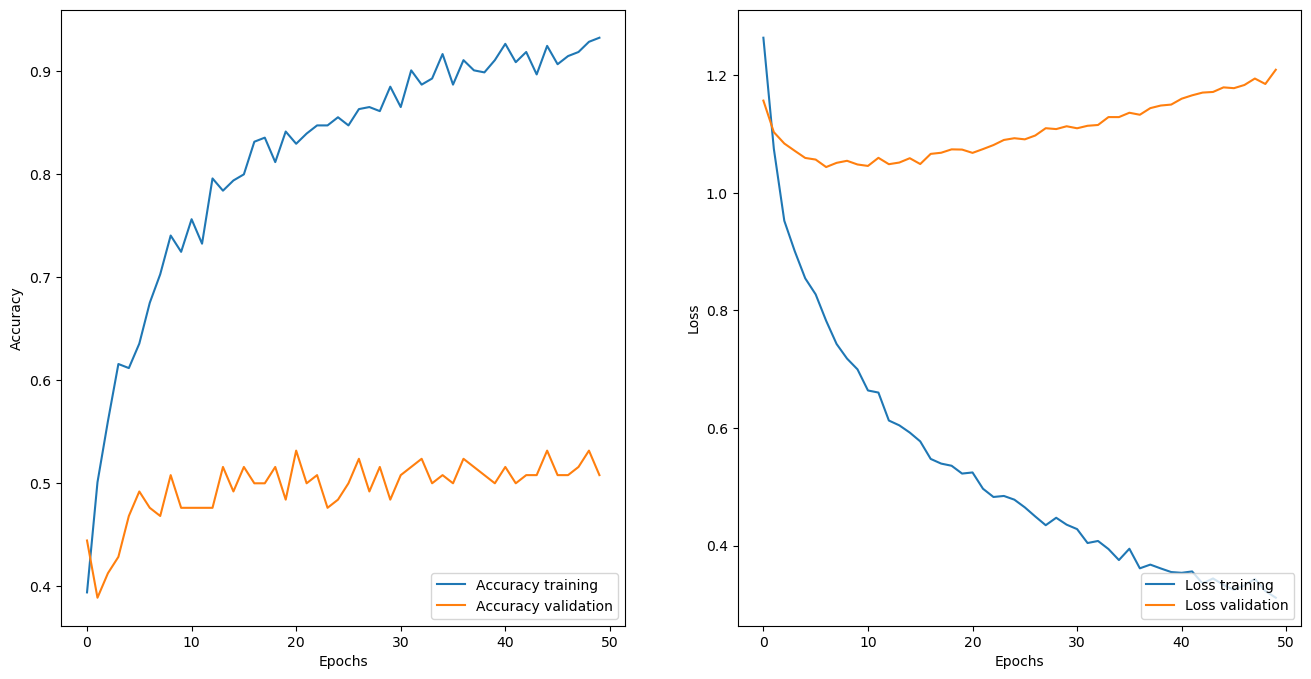

max_val_acc 0.5317460298538208
4/4 [==============================] - 14s 3s/step - loss: 1.0678 - accuracy: 0.5317
{'loss': 1.06779146194458, 'accuracy': 0.5317460298538208} 



Fold: 5


In [ ]:
import lib_model as mpp
import matplotlib.pyplot as plt

VALIDATION_ACCURACY = []
VALIDATION_LOSS = []


fold_var=1;
for train_index, val_index in kf.split(np.zeros(L),Y):
    training_data   = train_data.iloc[train_index]
    validation_data = train_data.iloc[val_index]

    print('\nFold:',fold_var);
    
    # CREATE NEW MODEL
    model, target_size = mpp.create_model('',model_type=model_type);
    model.summary()
    
    train_data_generator = idg.flow_from_dataframe(training_data, 
                                                   directory = dataset_base_dir,
                                                   target_size=target_size,
                                                   x_col = "filename", 
                                                   y_col = "label",
                                                   batch_size=BATCH_SIZE,
                                                   class_mode="categorical",
                                                   shuffle = True);
    
    valid_data_generator  = idg_val.flow_from_dataframe(validation_data, 
                                                    directory = dataset_base_dir,
                                                    target_size=target_size,
                                                    x_col = "filename", 
                                                    y_col = "label",
                                                    batch_size=BATCH_SIZE,
                                                    class_mode="categorical",
                                                    shuffle = True)
    
    STEPS_BY_EPOCHS=len(train_data_generator);
    

    
    # COMPILE NEW MODEL
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    # CREATE CALLBACKS
    best_model_file=os.path.join(output_dir,get_model_name(fold_var));
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=best_model_file, 
                                                    save_weights_only=True,
                                                    monitor='val_loss', 
                                                    save_best_only=True, 
                                                    verbose=1);
    
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    
    # There can be other callbacks, but just showing one because it involves the model name
    # This saves the best model
    # FIT THE MODEL
    history = model.fit(train_data_generator,
                        steps_per_epoch=STEPS_BY_EPOCHS,
                        epochs=EPOCAS,
                        validation_data=valid_data_generator,
                        callbacks=[checkpoint,tensorboard_callback],
                        verbose=1
                       );
    
    #PLOT HISTORY
    mpp.save_model_history(history,os.path.join(output_dir,"historical_"+str(fold_var)+".csv"),show=False);
    
    # LOAD BEST MODEL to evaluate the performance of the model
    model.load_weights(best_model_file);
    
    results = model.evaluate(valid_data_generator)
    results = dict(zip(model.metrics_names,results))
    print(results,"\n\n");
    
    VALIDATION_ACCURACY.append(results['accuracy'])
    VALIDATION_LOSS.append(results['loss'])
    
    tf.keras.backend.clear_session()
    
    fold_var += 1

In [ ]:
fpath=os.path.join(output_dir,"final_stats.m");
mean_val_acc=mpp.save_model_stat_kfold(VALIDATION_ACCURACY,VALIDATION_LOSS, fpath);

mpp.save_model_parameters(model, os.path.join(output_dir,'parameters_stats.m'));

os.rename(output_dir,output_dir+str(K)+'_'+model_type+'_acc'+str(int(mean_val_acc*10000)));
print(mean_val_acc)